## Лабораторная работа 1. Оганян 381808-1

In [306]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Загрузка изображения

In [307]:
src_image = cv2.imread('Lenna.png')
src_image.shape

(1200, 1200, 3)

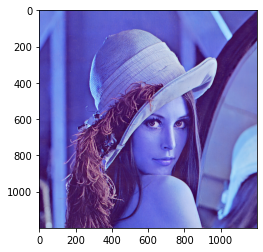

In [308]:
plt.imshow(src_image)

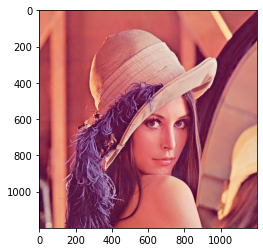

In [309]:
image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### 1. Поиск лица и отступ на 10% от границ

In [310]:
def find_face(src_image):
    img = src_image.copy()
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    faces = face_cascade.detectMultiScale(img, 1.1, 4)
    img_with_rectangles = img.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(img_with_rectangles, (x, y), (x+w, y+h), (255, 255, 255), 5)
    for (x, y, w, h) in faces:
        face_cropped = img[((int)(y * 0.9)): (y + int(h * 1.1)), ((int)(x*0.9)): (x + int(w * 1.1))].copy()
    return [img_with_rectangles, face_cropped]

<ipython-input-311-84609fcedcf4>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


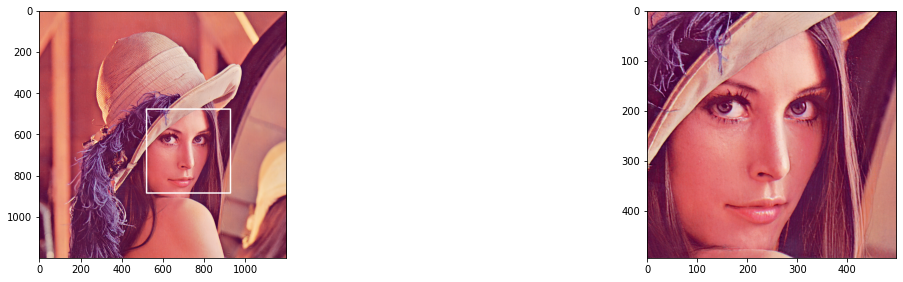

In [311]:
face_found, face_cropped = find_face(image)
images = [face_found, face_cropped]
plt.figure(figsize=(20,10))
columns = 2
for i, image_ in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_)

### 2. Бинарное изображение краёв без учета маленьких границ

In [312]:
def find_edges(image):
    img = image.copy()
    img = cv2.Canny(img, 80, 110)
    return img

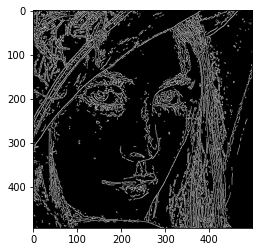

In [313]:
edges_img = find_edges(face_cropped)
plt.imshow(edges_img, cmap = 'gray')

In [314]:
def remove_small_edges(image):
    img2 = image.copy()
    output_image = image.copy()
    output_image[:] = 0
    contours, _ = cv2.findContours(img2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.boundingRect(c) for c in contours]
    num = 0
#     print(areas)
    for contour in areas:
        x,y,w,h = contour
        if (w > 10 and h > 10):
            cv2.drawContours(output_image, contours, num, (255,255,255), 1)
        num+=1
    return output_image

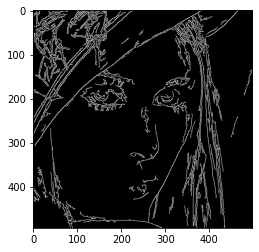

In [315]:
filtered_image = remove_small_edges(edges_img)
plt.imshow(filtered_image, cmap = 'gray')

### 3. Операция наращивания (матфорфология) + сглаживание + нормализация

In [316]:
def dilate(img):
    kernel = np.ones((5, 5), 'uint8')
    dilate_img = cv2.dilate(img, kernel, iterations=1)
    dilate_img = np.clip(dilate_img, 0,255)
    return dilate_img

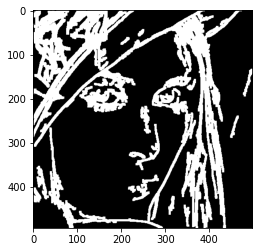

In [317]:
dilate_img = dilate(filtered_image)
plt.imshow(dilate_img, cmap='gray')

In [318]:
def Blur(img):
    image = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
    norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image

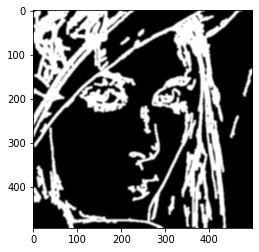

In [319]:
norm_img = Blur(dilate_img)
plt.imshow(norm_img, cmap='gray')

### 4. Билатеральная фильтрация

In [320]:
def Bilaterial(img):
    bilateral_blur = cv2.bilateralFilter(img,15, 75, 75)
    return bilateral_blur

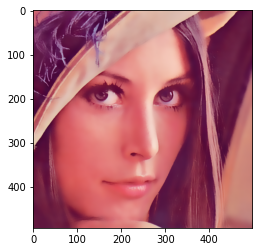

In [321]:
bil_img = Bilaterial(face_cropped)
plt.imshow(bil_img)

### 5. Повышенная контрастность

In [322]:
def ContrastIncrease(img):    
    gauss_img = cv2.GaussianBlur(img,(5,5), cv2.BORDER_DEFAULT) 
    img_contrast = cv2.addWeighted(img, 3.2, gauss_img, -2.1, 0).astype(np.uint8)
    img_contrast = np.clip(img_contrast, 0,255)
    return img_contrast

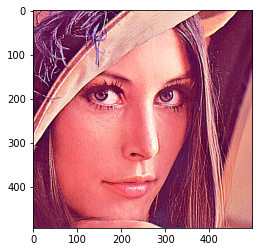

In [323]:
    img_contrast = ContrastIncrease(face_cropped)
    plt.imshow(img_contrast)

### 6. Финальная фильтрация

In [324]:
def GetFinalImage(M, F1, F2):
    final_img = np.ndarray(F1.shape)
    M_tmp = np.ndarray(F1.shape)
    M_tmp[:,:,0] = M[:,]
    M_tmp[:,:,1] = M[:,]
    M_tmp[:,:,2] = M[:,]
    final_img =  np.clip(M_tmp * F2 + (1 - M_tmp) * F1, 0, 255).astype(np.uint8)
    return final_img
    

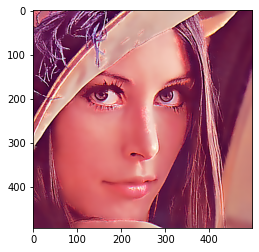

In [325]:
final_image = GetFinalImage(norm_img, bil_img, img_contrast)
plt.imshow(final_image)

### 7. Соберем все вместе

In [356]:
def SetAxes(axes, i, j, title, img):
    axes[i][j].set_title(title)
    axes[i][j].imshow(img, cmap = 'gray')
    axes[i][j].axis('off')

In [352]:
def FaceFilter(image):
    _, axes = plt.subplots(2, 4, figsize=(20, 30))
    SetAxes(axes, 0, 0, 'Source image', image)
    face_found, face_cropped = find_face(image)
    SetAxes(axes, 0, 1, 'Face detected', face_found)
    SetAxes(axes, 0, 2, 'Face cropped', face_cropped)
    edges_img = find_edges(face_cropped)
    filtered_image = remove_small_edges(edges_img)
    SetAxes(axes, 0, 3, 'Binary edges', filtered_image)
    dilate_img = dilate(filtered_image)
    norm_img = Blur(dilate_img)
    SetAxes(axes, 1, 0, 'Dilated image', norm_img)
    bil_img = Bilaterial(face_cropped)
    SetAxes(axes, 1, 1, 'Bilaterial-filtered image', bil_img)
    img_contrast = ContrastIncrease(face_cropped)
    SetAxes(axes, 1, 2, 'Increased-contrast image', img_contrast)
    final_image = GetFinalImage(norm_img, bil_img, img_contrast)
    SetAxes(axes, 1, 3, 'Final filtered image', final_image)
    return final_image    

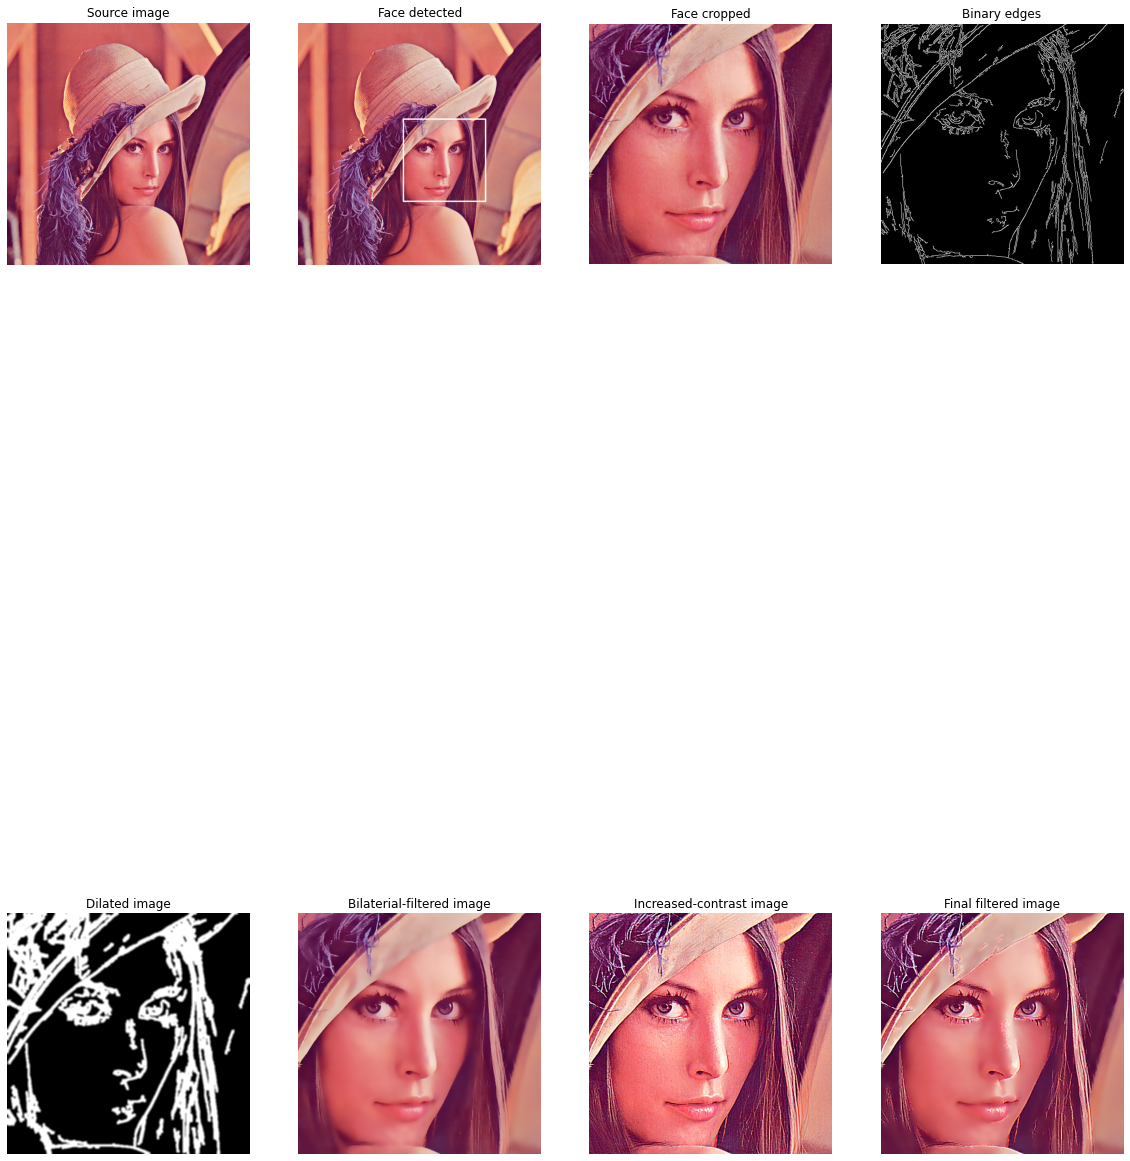

In [357]:
filtered_image = FaceFilter(image)